In [1]:
#import stuff
import torch
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure', dpi=300)
from glob import glob
import sys
sys.path.insert(0,"/home/sourav/MapArt/edgeDet/HED/pytorch-hed/")
from edgeModule import *
sys.path.insert(0, "/home/sourav/MapArt/modules/")
from image_processing import *
from scipy.interpolate import RectBivariateSpline as RBS
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from matplotlib.colors import LogNorm
from networkx.algorithms.components import connected_components
import potrace
import matplotlib.cm as cmap
import matplotlib.patches as patches

# Data I/O

In [2]:
datadir = "/home/sourav/MapArt/datasets/animals/animals/"
outdir = "/home/sourav/MapArt/datasets/inputs/"
animals = []
with open("/home/sourav/MapArt/datasets/input_animals.txt") as file:
    andirs = [line.rstrip() for line in file]
print (andirs)

imageList = []
for an in andirs:
    images = glob(datadir+an+'/*')
    imageList += images
    
datadir = "/home/sourav/MapArt/datasets/inputsv1/"
imageList = glob(datadir+"*")


['antelope', 'bat', 'bear', 'bee', 'bison', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cow', 'coyote', 'crow', 'deer', 'dog', 'dolphin', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fox', 'goldfish', 'goose']


# Select an Image

In [123]:
#select a random image
imidx = np.random.choice(len(imageList))
#load and view the image
filename = imageList[imidx]
img0 = cv.imread(filename)
#plt.imshow(img0)
if not(Qfilter(img0)): 
    imageList.remove(filename)
    print ("Low quality image.")


In [124]:
filename

'/home/sourav/MapArt/datasets/inputsv1/2e1937ab5b.jpg'

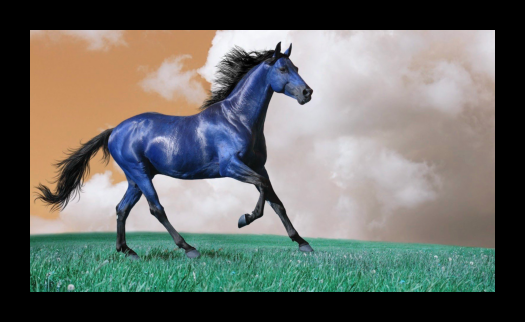

In [125]:
plt.figure().set_figwidth(2)
plt.imshow(cv.imread(filename))
plt.axis('off')
plt.show()

# 1. Start Image Processing

- Apply Theshold filter
- Scale the image pixel intensity and coordinates
- Run KNN filter
- Compute the interpolation function
- Generate a binary image


In [19]:
#initialize the image
improc = ImageProcessing(filename)
#apply threshold filter
improc.threshold_filter()
#perform scaling
improc.scale_image()
#perform knn filtering
improc.run_knn_filter()
#generate interpolator
improc.make_interpolator()
#get the binary bitmap
bimg = improc.binary_filter()

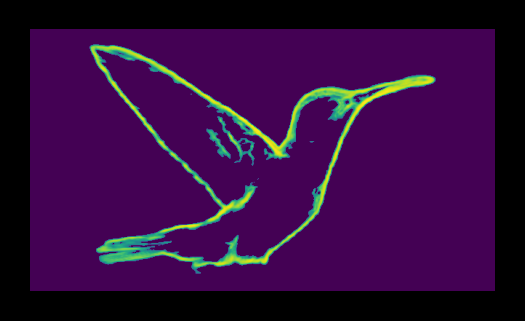

In [20]:
# Show cleaned image
plt.figure().set_figwidth(2)
plt.imshow(np.flipud(improc.imgEdge))
plt.axis('off')
plt.show()

# 2. Perform Image Tracing and Sequencing

In [9]:
imtrac = ImageTracing(bimg)
imtrac.apply_transform()
imtrac.apply_tracing()
rects = imtrac.rectangle_sq(improc, width=15, pad=5)

The image tracing produced 12 curves.


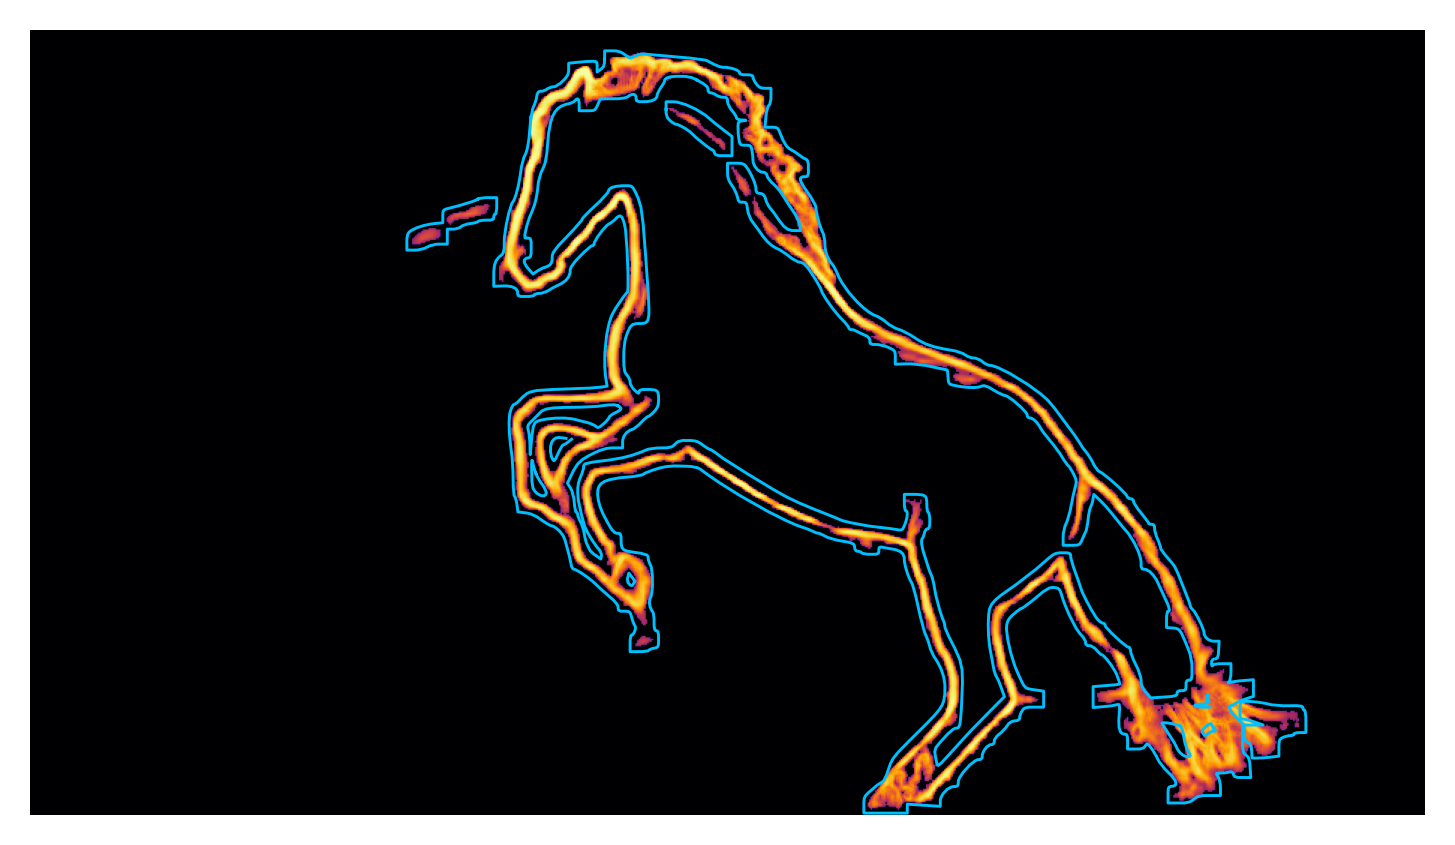

In [10]:
# Show the image with trace coverage
recox = np.array([])
recoy = np.array([])
#cmaps = cmap.viridis(np.linspace(0,1,len(path.curves)))
i=0
ncurves = len(imtrac.path.curves)

#plt.figure().set_figwidth(2)

for curve in imtrac.path:
    j=0
    tess = curve.tesselate()
    cmaps = cmap.bone(np.linspace(0.3,0.9,(len(tess))))
    plt.plot(tess[:,0], tess[:,1], color='deepskyblue', lw=0.7)
    #colorline(tess[:,0], tess[:,1], linewidth=1, cmap=plt.get_cmap('OrRd'))
    recox = np.append(recox, tess[:,0])
    recoy = np.append(recoy, tess[:,1])
    i +=1
    if i==ncurves: break

plt.imshow((improc.imgEdge), cmap='inferno')
plt.axis('off')
plt.ylim([0,improc.resy])
plt.show()

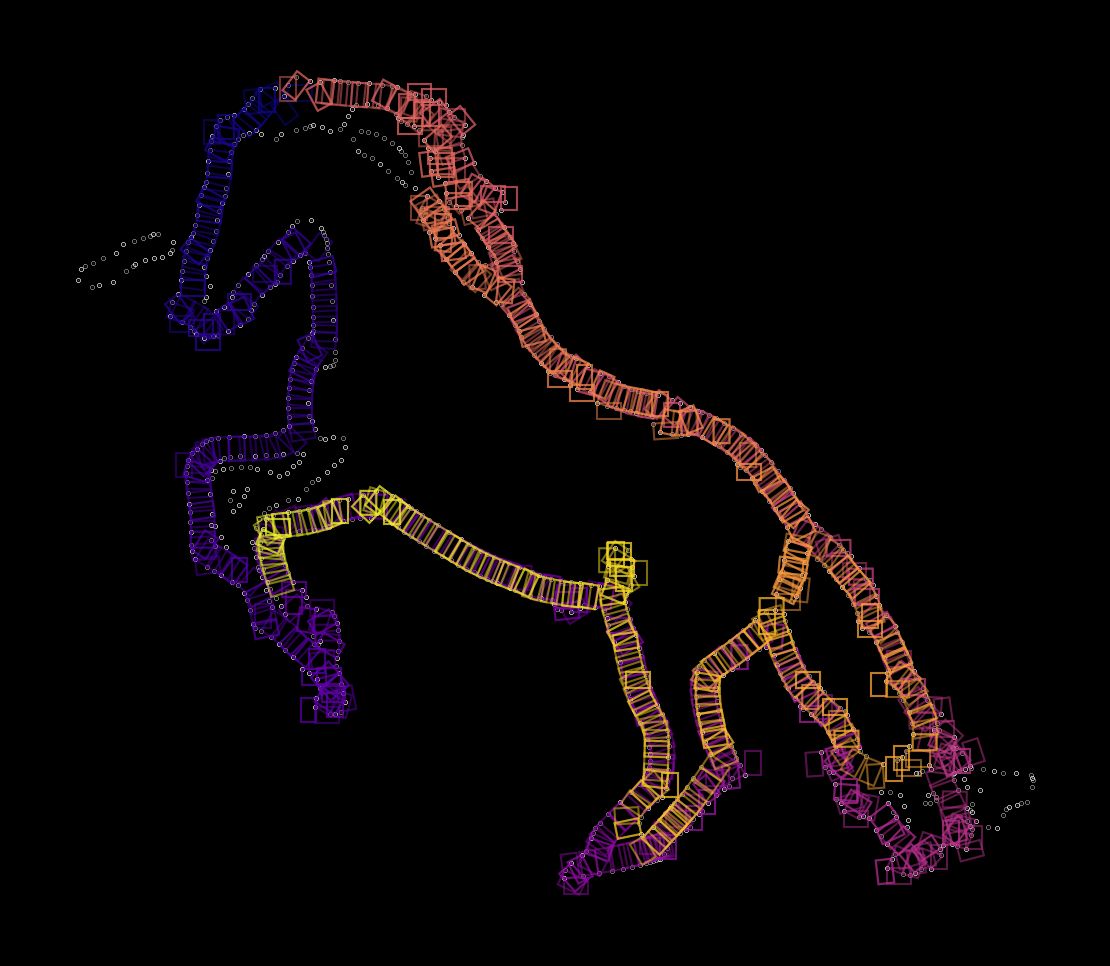

In [11]:
#plt.figure()
plt.style.use('dark_background')

fig, ax = plt.subplots()
ax.scatter(rects['p1x'], rects['p1y'], s=0.01, c='w')
#plt.scatter(recox[0], recoy[0], c='k')
#plt.scatter(recox[-1], recoy[-1], c='r')
#plt.scatter(evpointsx, evpointsy, s=0.5, c='k')

#num_rects = len(rects)
num_rects = 1000
cmaps = cmap.plasma(np.linspace(0,1,num_rects))

for i in range(num_rects):
    rect = rects[i]
    ax.add_patch(patches.Polygon([(rect['p1x'], rect['p1y']),
                                 (rect['p2x'], rect['p2y']),
                                 (rect['p3x'], rect['p3y']),
                                 (rect['p4x'], rect['p4y'])], 
                                 facecolor='none', edgecolor=cmaps[i], alpha=0.5,
                                linewidth=0.5))
ax.set_aspect(1)
plt.axis('off')

plt.show()

# 03. Ordering of scattered point

In [49]:
#check the scatter plot
x = improc.xcord.reshape(-1)
y = improc.ycord.reshape(-1)
z = improc.imgEdge.reshape(-1)

filtidx = np.where(z>0)[0]
num_pix = 1000
testidx = np.random.choice(filtidx, num_pix, replace=False)
# prepare a set of test points
testpoints = np.zeros(num_pix, dtype=[('x',float), ('y', float)])
testpoints['x'] = x[testidx]
testpoints['y'] = y[testidx]

# prepare the sequence of boxes
boxes = rects.copy()
keys = ['p1x', 'p1y', 'p2x', 'p2y',
       'p3x', 'p3y', 'p4x', 'p4y']

for key in keys:
    boxes[key] /= improc.scale_norm


In [56]:
seq = Sequencer(testpoints, boxes)
seq.start_sequence(tolerance=10)

In [57]:
segs = []
tdict = seq.seq_dict
for key,val in tdict.items():
    #print (key)
    #print (len(val))
    arr = np.zeros((len(val), 2))
    point = val.head
    i=0
    arr[i,0] = testpoints[point.data][0]
    arr[i,1] = testpoints[point.data][1]
    #print (key)
    while point.next:
        i +=1
        point = point.next
        arr[i,0] = testpoints[point.data][0]
        arr[i,1] = testpoints[point.data][1]
    segs.append(arr)
    #print (len(val))

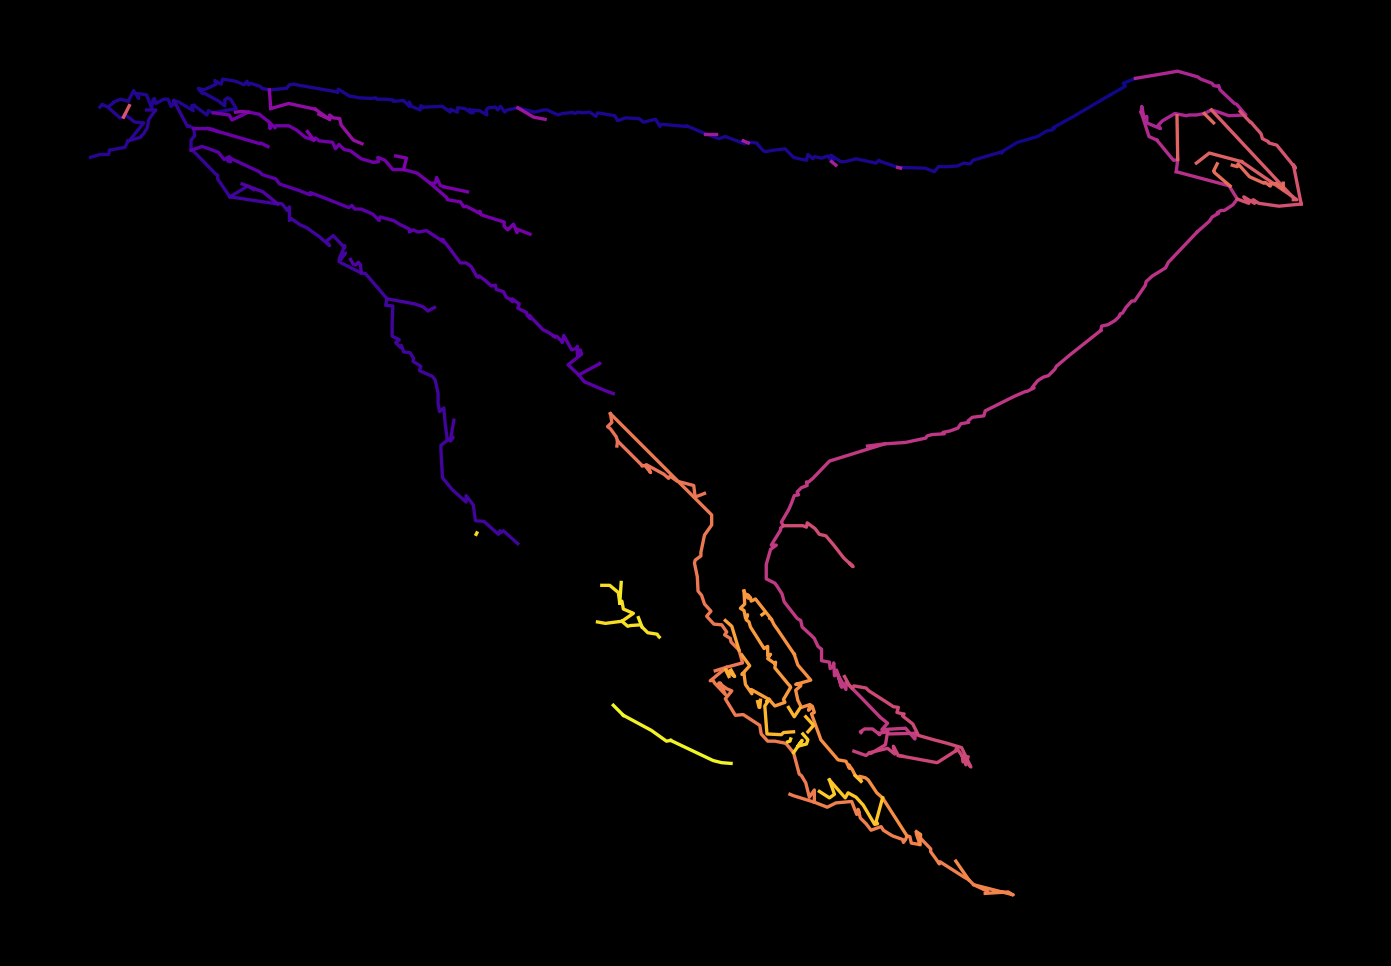

In [58]:
cmaps = cmap.plasma(np.linspace(0,1,len(segs)))
i=0
#plt.figure()
fig, ax = plt.subplots()

for s in segs:
    ax.plot(s[:,0], s[:,1], lw=0.8, color=cmaps[i])
    i+=1

#plt.xlim([0.3,0.5])
#plt.ylim([0,0.4])
ax.set_aspect(1)
plt.axis('off')

plt.show()

# Make animation

In [88]:
frames[0].shape

(400, 600, 3)

# !!!!!!!!!!!!!!!! Dev. Stage !!!!!!!!!!!!!!!!!!!!!

In [18]:
class Node:
    def __init__(self, data):
        self.data = data
        self.next = None

class LinkedList:
    def __init__(self):
        self.head = None
        self.tail = None
        self.len = 0
    
    def __len__(self):
        return self.len
    
    def append(self, data):
        self.len += 1
        new_node = Node(data)
        if not self.head:
            self.head = new_node
            self.tail = new_node
        else:
            self.tail.next = new_node
            self.tail = new_node

    def display(self):
        current = self.head
        while current:
            print(current.data, end=" -> ")
            current = current.next
        print("None")

    

In [66]:
llist = LinkedList()
print (len(llist))

0


3


In [25]:
from functools import reduce

def dot_product(vec1, vec2):
    return vec1[0] * vec2[0] + vec1[1] * vec2[1]

def is_point_in_rect(point, rect):
    for i in range(4):
        p1 = rect[i]
        p2 = rect[(i + 1) % 4]
        p4 = rect[(i + 3) % 4]
        
        edge_vector = np.array([p2[0] - p1[0], p2[1] - p1[1]])
        normal_probe = np.array([p4[0] - p1[0], p4[1] - p1[1]])
        
        normal_vector1 = np.array([edge_vector[1], -edge_vector[0]])
        normal_vector2 = np.array([-edge_vector[1], edge_vector[0]])

        dot1 = dot_product(normal_probe, normal_vector1)
        dot2 = dot_product(normal_probe, normal_vector2)
        if dot1<0: normal_vector = normal_vector1
        elif dot2<0: normal_vector = normal_vector2
        else: assert False, "check bug"

        point_vector = np.array([point[0] - p1[0], point[1] - p1[1]])

        if dot_product(point_vector, normal_vector) > 0:
            return False
    return True

def points_in_rect(rect, points):
    inidxs = []
    big_minx = reduce(np.minimum,
                     (rect['p1x'],rect['p2x'], rect['p3x'], rect['p4x']))
    big_maxx = reduce(np.maximum,
                     (rect['p1x'],rect['p2x'], rect['p3x'], rect['p4x']))
    big_miny = reduce(np.minimum,
                     (rect['p1y'],rect['p2y'], rect['p3y'], rect['p4y']))
    big_maxy = reduce(np.maximum,
                     (rect['p1y'],rect['p2y'], rect['p3y'], rect['p4y']))
    
    #big_minx = np.minimum(rect['p1x'],rect['p2x'], rect['p3x'], rect['p4x'])
    #big_maxx = np.maximum(rect['p1x'],rect['p2x'], rect['p3x'], rect['p4x'])
    #big_miny = np.minimum(rect['p1y'],rect['p2y'], rect['p3y'], rect['p4y'])
    #big_maxy = np.maximum(rect['p1y'],rect['p2y'], rect['p3y'], rect['p4y'])
    
    xrange = np.where((points['x']>=big_minx)&(points['x']<=big_maxx))[0]
    yrange = np.where((points['y']>=big_miny)&(points['y']<=big_maxy))[0]
    
    filtidx = np.intersect1d(xrange, yrange, assume_unique=True)
    if len(filtidx)==0: return None
    
    for idx in filtidx:
        p = points[idx]
        recpoints = [(rect['p1x'], rect['p1y']),
                    (rect['p2x'], rect['p2y']),
                    (rect['p3x'], rect['p3y']),
                    (rect['p4x'], rect['p4y'])]
        
        inside = is_point_in_rect((p['x'], p['y']), recpoints)
        if inside: inidxs.append(idx)
    
    if len(inidxs)==0: return None
    return inidxs

    
    
    

In [70]:
def distance(p1,p2):
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)


class Sequencer:
    '''Class to order the given set of points so that
    the consecutive connections create the underlying
    line drawing'''
    def __init__(self, points, rects):
        self.points = points
        self.boxes = rects
        #mask to track which points are sequenced
        self.mask = np.repeat(False, len(points))
        #initialize empty sequence dictionary
        self.seq_dict = {}
        
    def is_sequenced(self, idx):
        '''Check if the point is already sequenced'''
        #print (self.mask)
        #print (idx)
        return self.mask[idx]

    def order_multiple(self, idlist, rect):
        '''In case there are multiple pouints in the box,
        order the points based on the distance from the 
        first corner of the box.'''
        dlist = []
        #loop over the points
        for idx in idlist:
            p1 = self.points[idx]
            p2 = (rect['p1x'], rect['p1y'])
            dist = distance(p1,p2)
            dlist.append(dist)
        #get the sorted ids
        sort_order = np.argsort(np.array(dlist))
        #print (idlist)
        #print (sort_order)
        return list(np.array(idlist)[sort_order])
    
    def start_sequence(self, tolerance=20):
        '''The parent function that executes the
        sequencing.
        Args: Tolerance (int): number of consecutive
        empty boxes (no points) after which a new
        sequence is started.'''
        #initialize stuff
        #blank linked list
        llist = LinkedList()
        #running curve number
        current_curve = 0
        #running segment tracker
        seg_iter = 0
        #initialize the previous and current seq. points
        prev_node = None
        curr_node = None
        
        #number of consecutive boxes without any points
        miss_tol = 0
        
        #start the box loop
        for i, box in enumerate(self.boxes):
            #=========== section for checking new sequence
            #if the current box is part of the next
            #curve, start a new linked list
            if box['curve_num']!=current_curve:
                #store the last sequenced segment
                #and update the segment tracker
                #print (f"Moving to curve: {box['curve_num']}")
                if len(llist)>1:
                    self.seq_dict[seg_iter] = llist
                    seg_iter += 1
                #start a new sequence and update the curve number
                llist = LinkedList()
                current_curve = box['curve_num']
                miss_tol = 0

            if (box['curve_num']==current_curve and
               miss_tol>=tolerance):
                if len(llist)>1:
                    self.seq_dict[seg_iter] = llist
                    seg_iter += 1
                #start a new sequence with head being the
                #previous node
                llist = LinkedList()
                llist.append(prev_node)
            
            #============ Section for treating points inside the box    
            #get the point idxs inside current box
            in_box = points_in_rect(box, self.points)
            
            #deal with the returned points
            if in_box is None:#empty box
                miss_tol += 1
                continue
                
            elif len(in_box)==1:#only one point
                if self.is_sequenced(in_box[0]):
                    miss_tol += 1
                    prev_node = in_box[0]
                    continue
                else:
                    llist.append(in_box[0])
                    self.mask[in_box[0]] = True
                    miss_tol = 0

            else:#multiple points in the box
                #order the points
                sortedid = self.order_multiple(in_box,
                                              box)
                #remove the points that are already sequenced
                update_box = []
                for idx in sortedid:
                    if self.is_sequenced(idx): continue
                    update_box.append(idx)
                #if no point survives, 
                if len(update_box)==0:
                    miss_tol += 1
                    prev_node = sortedid[-1]
                    
                else:
                    for nidx in update_box:
                        llist.append(nidx)
                        self.mask[nidx] = True
                    miss_tol = 0
            

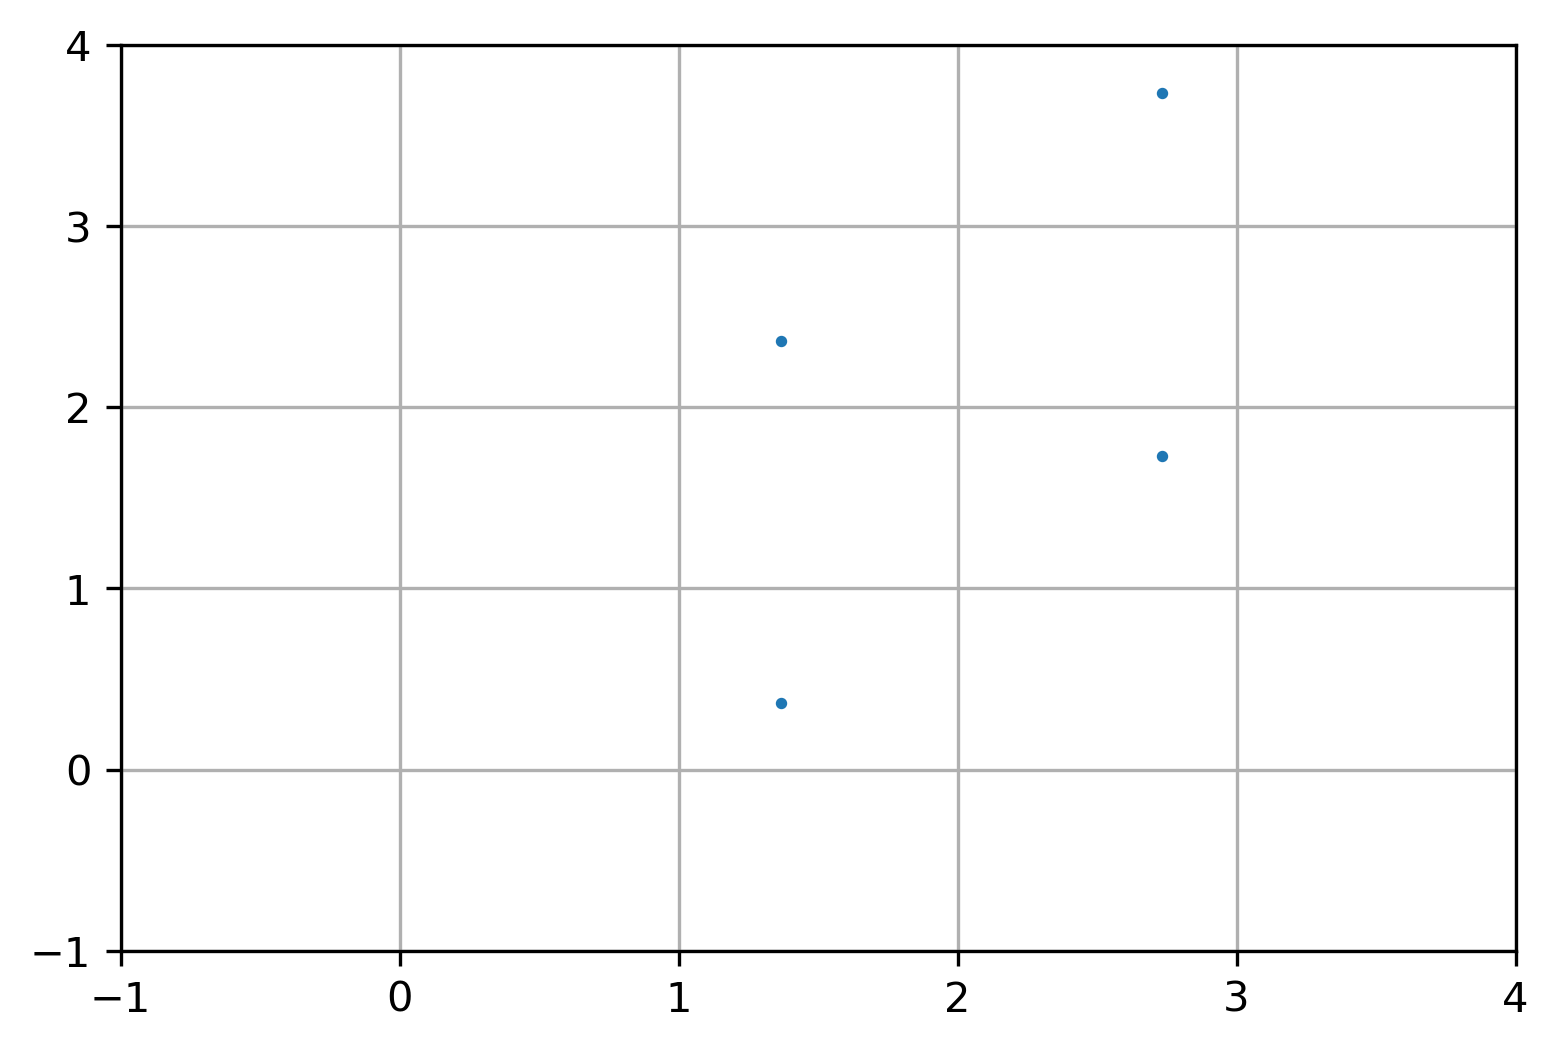

In [53]:
# Example usage:
p1 = (1.3660254037844388, 0.36602540378443843)
p2 = (2.7320508075688776, 1.7320508075688772)
p3 = (2.732050807568877, 3.732050807568877)
p4 = (1.3660254037844384, 2.3660254037844384)

rotated_rectangle = [p1, p2, p3, p4]
plt.figure()
plt.scatter([p[0] for p in [p1,p2,p3,p4]],
            [p[1] for p in [p1,p2,p3,p4]], s=3)
plt.xlim([-1,4])
plt.ylim([-1,4])
plt.grid()
plt.show()

In [59]:
p = (2,2)
is_point_in_rect(p,rotated_rectangle)

True